In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import matplotlib.pyplot as plt


2023-12-13 21:14:29.720594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading DF

In [2]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3373 non-null   object 
 1   Open       3373 non-null   float64
 2   High       3373 non-null   float64
 3   Low        3373 non-null   float64
 4   Close      3373 non-null   float64
 5   Adj Close  3373 non-null   float64
 6   Volume     3373 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 184.6+ KB


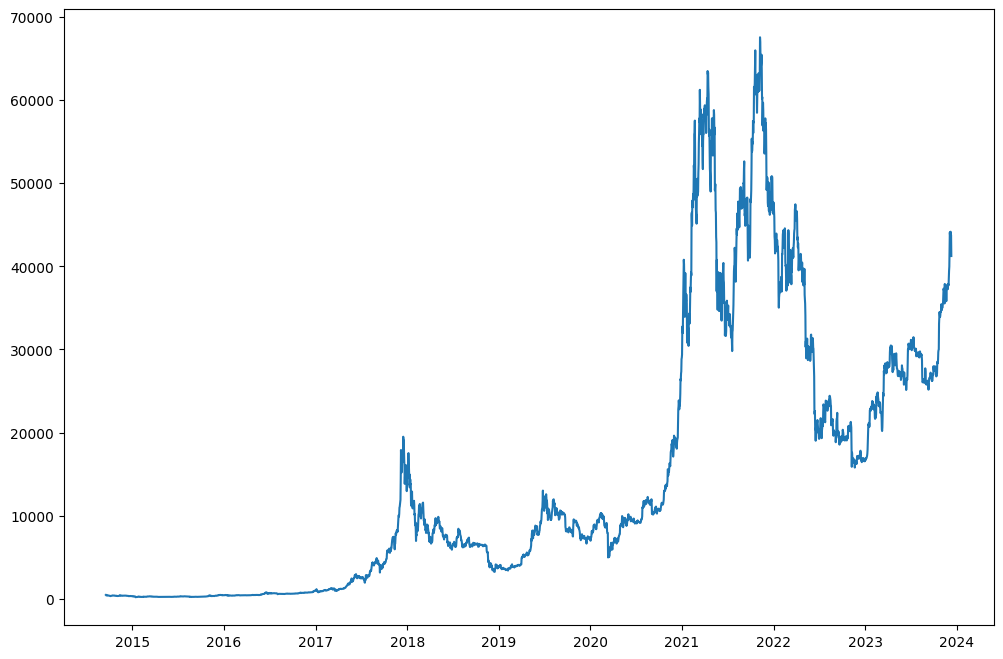

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12,8))
plt.plot(df['Date'],df['Close'])

# Prepare Data

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Close_normalized'] = scaler.fit_transform(df[['Close']])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/valid

In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_normalized
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.004144
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,0.003655
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,0.003216
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.003425
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,0.003275


In [13]:
timesteps = df['Date'].to_numpy()
prices = df['Close_normalized'].to_numpy()
timesteps[:5],prices[:5]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ]))

In [18]:
def create_train_test_split(timesteps,prices, test_size=0.2):
    split_size = int((1-test_size)*len(timesteps))
    X_train,X_test = timesteps[:split_size], timesteps[split_size:]
    y_train,y_test = prices[:split_size], prices[split_size:]
    return X_train,X_test,y_train,y_test

In [19]:
X_train,X_test,y_train,y_test = create_train_test_split(timesteps,prices)

In [20]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2698, 675, 2698, 675)

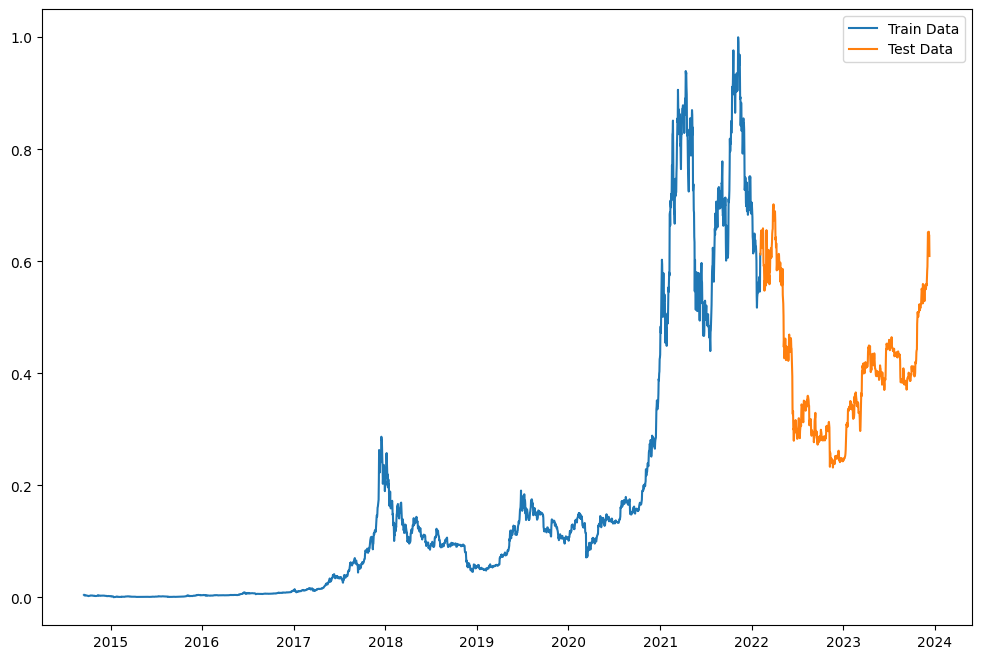

In [21]:
plt.figure(figsize=(12,8))
plt.plot(X_train,y_train, label='Train Data')
plt.plot(X_test,y_test, label='Test Data')
plt.legend();

# Windowing Dataset

In [22]:
WINDOW_SIZE = 60
HORIZON = 1

In [27]:
def get_label_windows(df, horizon=1):
    """
  Creates labels for windowed dataset.
    """
    return df[:,:-horizon], df[:,-horizon:]

In [28]:
test_window,test_label = get_label_windows(tf.expand_dims(tf.range(11),axis=0),horizon=1)
print(tf.squeeze(test_window).numpy), print(tf.squeeze(test_label))

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>>
tf.Tensor(10, shape=(), dtype=int32)


(None, None)

In [32]:
def make_windows(x, window_size, horizon):
    window_step = np.arange(len(x)-(window_size+horizon-1))
    window_index = window_step + np.expand_dims(np.arange(window_size + horizon), axis=0).T 
    window_array = x[window_index]
    windows, labels = get_label_windows(window_array, horizon=horizon)
    return windows, labels

In [35]:
full_windows,full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows,full_labels


(array([[0.00414359, 0.00365546, 0.00321557, ..., 0.40667893, 0.40382002,
         0.39613774],
        [0.00365546, 0.00321557, 0.00342492, ..., 0.40382002, 0.39613774,
         0.39440865],
        [0.00321557, 0.00342492, 0.0032753 , ..., 0.39613774, 0.39440865,
         0.39597532],
        ...,
        [0.00326041, 0.00293862, 0.00311297, ..., 0.64652273, 0.63978894,
         0.65275754],
        [0.00293862, 0.00311297, 0.00310593, ..., 0.63978894, 0.65275754,
         0.6462191 ],
        [0.00311297, 0.00310593, 0.00292475, ..., 0.65275754, 0.6462191 ,
         0.64701619]]),
 array([[0.39440865],
        [0.39597532],
        [0.39596541],
        [0.4003867 ],
        [0.42056537],
        [0.41902625],
        [0.41772921],
        [0.42353826],
        [0.4378306 ],
        [0.4413247 ],
        [0.44244484],
        [0.4883329 ],
        [0.50043126],
        [0.50935401],
        [0.50421707],
        [0.50055403],
        [0.50322174],
        [0.50988318],
        [0.50